In [931]:
## Import Some Libraries
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [932]:
class LoadModel:
    def __init__(self, file_path):
        with open(file_path, 'r') as f:
            model_data = json.load(f)
        
        layers = model_data['layers']
        n_layers = len(layers)
        
        self.weights = []
        self.biases = []
        self.activations = []
        self.sigmoid_gradient = lambda x: x * (1 - x)
        self.relu_gradient = lambda x: 1. * (x > 0)
        self.tanh_gradient = lambda x: 1 - np.tanh(x)**2
        self.softmax_gradient = lambda x: x * (1 - x)
        
        for i in range(1, n_layers):
            layer = layers[i]
            
            if layer['tipe'] == 'hidden':
                n_neurons = layer['n_neuron']
                weight = np.array(layer['weight']).astype(np.float64)
                bias = np.array(layer['bias']).astype(np.float64)
                activation = layer['activation_function']
                
                self.weights.append(weight)
                self.biases.append(bias)
                self.activations.append(activation)
                
            elif layer['tipe'] == 'output':
                n_neurons = layer['n_neuron']
                weight = np.array(layer['weight']).astype(np.float64)
                bias = np.array(layer['bias']).astype(np.float64)
                activation = layer['activation']
                
                self.weights.append(weight)
                self.biases.append(bias)
                self.activations.append(activation)
                
    def get_weights(self):
        return self.weights
    
    def get_biases(self):
        return self.biases
    
    def get_activations(self):
        return self.activations
    
    def get_layer(self, layer):
        return self.weights[layer], self.biases[layer], self.activations[layer]
    
    def get_layer_weights(self, layer):
        return self.weights[layer]
    
    def get_layer_biases(self, layer):
        return self.biases[layer]
    
    def get_layer_activations(self, layer):
        return self.activations[layer]
    
    def get_model(self):
        return self.weights, self.biases, self.activations
    
    def get_activation_gradient(self, activation):
        if activation == 'relu':
            return lambda x: 1. * (x > 0)
        elif activation == 'sigmoid':
            return lambda x: x * (1. - x)
        elif activation == 'linear':
            return lambda x: np.ones_like(x)
        elif activation == 'softmax':
            return lambda x: x * (1. - x)

    
    # print model per layer
    def print_model(self):
        for i in range(len(self.weights)):
            print('Layer', i+1)
            print('Weights:', self.weights[i])
            print('Biases:', self.biases[i])
            print('Activations:', self.activations[i])
            print('')

Layer 1
Weights: [[1.00232325 0.99535603]
 [1.00029911 0.99940204]]
Biases: [-6.47692259e-04 -1.00064769e+00]
Activations: relu

Layer 2
Weights: [[ 1.00077587]
 [-1.99922413]]
Biases: [-0.01768386]
Activations: linear



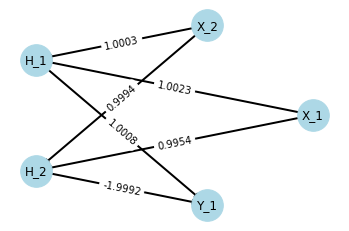

In [933]:
class FFNN:
    def __init__(self, model_path):
        self.model = LoadModel(model_path)
        self.weights = self.model.get_weights()
        self.biases = self.model.get_biases()
        self.activations = self.model.get_activations()

    def forward_propagation(self, X):
        input_layer = X
        self.layer_outputs = []  # save outputs of each layer
        n_layers = len(self.weights) + 1
        for i in range(n_layers - 1):
            dot_product = np.dot(input_layer, self.weights[i]) + self.biases[i]
            if self.activations[i] == 'relu':
                output_layer = np.maximum(0, dot_product)
            elif self.activations[i] == 'sigmoid':
                output_layer = 1 / (1 + np.exp(-dot_product))
            elif self.activations[i] == 'linear':
                output_layer = dot_product
            elif self.activations[i] == 'softmax':
                output_layer = np.exp(dot_product) / np.sum(np.exp(dot_product), axis=0)
            input_layer = output_layer
            self.layer_outputs.append(input_layer)

        return output_layer

    def backward_propagation(self, X, y_true, learning_rate):
        # compute output error
        y_pred = self.layer_outputs[-1]
        error = y_pred - np.array(y_true).reshape(-1, 1)
        output_error = error

        # update weights and biases of output layer
        n_layers = len(self.weights) + 1
        for i in range(n_layers - 2, -1, -1):
            output_layer = self.layer_outputs.pop()
            dot_product = np.dot(output_layer.T, output_error)
            if self.activations[i] == 'relu':
                derivative = np.where(output_layer > 0, 1, 0)
            elif self.activations[i] == 'sigmoid':
                derivative = output_layer * (1 - output_layer)
            elif self.activations[i] == 'linear':
                derivative = 1
            
            output_error = np.dot(output_error, self.weights[i].T) * derivative

            self.weights[i] -= learning_rate * dot_product
            self.biases[i] -= learning_rate * np.sum(output_error[0], axis=0)

    def train(self, X, y_true, learning_rate, epochs, batch_size):
        for epoch in range(epochs):
            # shuffle the training data
            p = np.random.permutation(len(X))
            X, y_true = X[p], y_true[p]

            # split the data into mini-batches
            for i in range(0, len(X), batch_size):
                X_batch, y_batch = X[i:i+batch_size], y_true[i:i+batch_size]

                # forward propagation
                self.forward_propagation(X_batch)

                # backward propagation
                self.backward_propagation(X_batch, y_batch, learning_rate)

            y_pred = self.predict(X)
            loss = np.mean((np.array(y_pred).flatten() - y_true) ** 2)

            if loss < 0.01:
                break


    def predict(self, X):
        if len(X.shape) == 1:
            return self.forward_propagation(X)
        else:
            predictions = []
            for instance in X:
                predictions.append(self.forward_propagation(instance))
            return np.array(predictions)

    def accuracy(self, X, y_true):
        y_pred = self.predict(X)
        y_pred = (y_pred >= 0.5).astype(int)
        return np.mean(y_pred == y_true)

    def print_model(self):
        self.model.print_model()

    def draw_network(self):
        G = nx.DiGraph()

        # add nodes
        input_nodes = [f'X_{i + 1}' for i in range(len(self.weights[0]))]
        G.add_nodes_from(input_nodes, layer='Input')

        hidden_nodes = [f'H_{i + 1}' for i in range(len(self.weights[0][0]))]
        G.add_nodes_from(hidden_nodes, layer='Hidden')

        output_nodes = [f'Y_{i + 1}' for i in range(len(self.weights[-1][0]))]
        G.add_nodes_from(output_nodes, layer='Output')

        # add edges
        for i in range(len(self.weights) - 1):
            for j in range(len(self.weights[i])):
                for k in range(len(self.weights[i][j])):
                    G.add_edge(input_nodes[j], hidden_nodes[k], weight=round(self.weights[i][j][k], 4))

        for i in range(len(self.weights[-1])):
            for j in range(len(self.weights[-1][0])):
                G.add_edge(hidden_nodes[i], output_nodes[j], weight=round(self.weights[-1][i][j], 4))

        # draw network
        pos = nx.circular_layout(G)
        nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
        nx.draw_networkx_edges(G, pos, width=2, edge_color='black')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'))
        nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
        plt.axis('off')
        plt.show()


# main function
def main():
    # load model
    # filename = input("Enter the filename: ")
    filename = 'relu'
    model_path = filename + '.json'
    model = FFNN(model_path)

    # visualize input layer
    X_train = np.array([[0,0], [0,1], [1,0], [1,1]])
    Y_train = np.array([1, 1, 1, 0])

    # train model
    model.train(X_train, Y_train, learning_rate=0.001, epochs=100, batch_size=1)

    # print model
    model.print_model()

    # draw network
    model.draw_network()

if __name__ == '__main__':
    main()